# <span style="color:#FF8800"> Load data & generate features

In [1]:
import os
import pandas as pd

In [2]:
train_df = pd.read_csv("datasets/train_data.tsv", 
                       sep = "\t",
                       usecols = ["label","label_binary","text"]
                      )

In [3]:
print(train_df.shape)
train_df.sample(3)

(15928, 3)


,label,label_binary,text
1417,No_Propaganda,No_Propaganda,that he had information from anonymous sources...
11978,No_Propaganda,No_Propaganda,"financially by George Soros’s money, Ford’s la..."
6407,"Name_Calling,Labeling",Propaganda,a very principled individual


> ### The training data, which was created in generate_data.ipynb, contains +15,900 samples with binary and multi-class labels. Here we'll focus on multi-class classification.

In [4]:
import textstat

In [5]:
train_df["sent_count"] = train_df.apply(lambda x: textstat.sentence_count(x["text"]), axis = 1) # number of sentences in span
train_df["flesch_reading"] = train_df.apply(lambda x: textstat.flesch_reading_ease(x["text"]), axis = 1) # Flesch reading ease score, higher is easier to read
train_df["difficult_words"] = train_df.apply(lambda x: textstat.difficult_words(x["text"]), axis = 1) # count of words with 2 or more syllables, seems like low threshold
train_df["read_index"] = train_df.apply(lambda x: textstat.automated_readability_index(x["text"]), axis = 1) # approximates the grade level needed to comprehend the text
train_df["syllable_count"] = train_df.apply(lambda x: textstat.syllable_count(x["text"]), axis = 1) # count of the number of syllables in the given text
train_df["text_standard"] = train_df.apply(lambda x: textstat.text_standard(x["text"], float_output = True), axis = 1) # combines a number of readability scores, the estimated school grade level to understand text
train_df["text_len"] = train_df.apply(lambda x: len(x["text"]), axis = 1) # the length of the text

In [6]:
text_stats = round(train_df.groupby("label_binary").mean(),1)
text_stats.T

label_binary,No_Propaganda,Propaganda
sent_count,1.2,1.1
flesch_reading,67.2,44.5
difficult_words,3.2,2.2
read_index,8.3,10.7
syllable_count,18.8,12.6
text_standard,7.8,7.9
text_len,75.0,48.3


> ### Based on research into related work it appears that creating some linguistic features from the sample text may help with the classification task.
> ### <span style="color:#8800ff"> In fact, we can see that texts featuring propaganda are shorter (text_len), more difficult to read (flesch_reading, lower is harder to understand), and contain fewer syllables (syllable_count) than texts without propaganda.

In [7]:
feature_cols = ['text', 'sent_count', 'flesch_reading',
                'difficult_words', 'read_index', 'syllable_count',
                'text_standard','text_len']

# <span style="color:#FF8800"> Train test split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df[feature_cols], 
    train_df["label"], 
    train_size = 0.7, 
    random_state = 3, 
    shuffle = True, 
    stratify = train_df["label"])

> ### Here we're creating a training and testing split from just the training data so we can perform grid search and tune the hyperparameters.
> ### We're using a standard 70-30 training testing split, shuffling the samples, and stratifying the samples so the training and testing data contain similar proportions of the labels.

# <span style="color:#FF8800"> Transform features

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
word_vectorizer = TfidfVectorizer(
    strip_accents = "unicode", 
    lowercase = True,
    stop_words = "english", 
    analyzer = "word", 
    token_pattern = "[a-z]+", 
    smooth_idf = True, 
    ngram_range=(1,3)
)

> ### We want to create a tf-idf statistic based on the text in the samples in order to utilize insights related to how informative words are based on how frequently they are used 1) in the corpus overall and 2) in a particular sample.
> ### TfidfVectorizer will generate a sparse matrix.
> ### We're employing smoothing so each token is counted at least once in the vocabulary. This is more relevant when we apply the tfidf created here to the testing data we split out earlier.

In [12]:
from sklearn.compose import ColumnTransformer

In [13]:
column_trans = ColumnTransformer([('tfidf', word_vectorizer, 'text')], remainder = "passthrough")
train_transformed = column_trans.fit_transform(X_train[feature_cols])

> ### <span style="color:#8800ff"> ColumnTransformer is useful here since it allows us to apply the tf-idf vectorizer to the sample text and "pass-through" the other features so we end up with a complete and coherent sparse matrix. If we didn't use "passthrough" in ColumnTransformer then we would have to map the columns of the other features onto the SciPy Compressed Sparse Row Matrix ourselves which is a bit challenging due to its structure.

# <span style="color:#FF8800"> Perform grid search

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [15]:
logistic_regression = LogisticRegression(n_jobs = -1)

param_grid = [{
        "penalty":["l2","none"],
        "C":[10000,1000,1],
        "fit_intercept": [True, False],
        "class_weight": [None, "balanced"],
        "solver": ["lbfgs","liblinear"] #! running this with other solvers like "sag" or "newton-cg" will result in a wait of several hours
}]

grid_search = GridSearchCV(
    estimator = logistic_regression,
    param_grid = param_grid,
    cv = 10
)

In [16]:
%%time
grid_search.fit(train_transformed, y_train)

/home/bryan/Documents/Code/python-environments/SI630/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/bryan/Documents/Code/python-environments/SI630/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bryan/Documents/Code/python-environments/SI630/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/home/bryan/Documents/Code/python-environments/SI630/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these paramete

CPU times: user 2h 3min 36s, sys: 1h 44min 54s, total: 3h 48min 30s
Wall time: 1h 29min 54s


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10000, 1000, 1],
                          'class_weight': [None, 'balanced'],
                          'fit_intercept': [True, False],
                          'penalty': ['l2', 'none'],
                          'solver': ['lbfgs', 'liblinear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=

In [17]:
grid_search.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

> ### We can access various attributes of the grid search we just performed including the best performing estimator above.
> ### Since we didn't provide an argument for the 'scoring' parameter in GridSearchCV it defaulted to the estimator's scoring method which for a multi-class classification task is subset accuracy which requires that "the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true." This is a fairly rigid approach. Other options are "f1", "f1_micro", "precision", "jaccard", and many others. 

# <span style="color:#FF8800"> Best logistic regression model
> ### Based on a more extensive grid search I performed previously I opted to use the model parameterized below.
> ### Here we'll fit the best logistic regression model on all of the training data and evaluate it on the data from the dev dataset.

In [18]:
best_lr = LogisticRegression(C = 10000, class_weight = 'balanced', dual = False,
                   fit_intercept = True, intercept_scaling = 1, l1_ratio = None,
                   max_iter = 100, multi_class = 'auto', penalty = 'l2',
                   random_state = 234, solver = 'liblinear', tol = 0.0001, verbose = 0,
                   warm_start = False)

In [19]:
all_train_transformed = column_trans.fit_transform(train_df[feature_cols]) # transform all of training data

In [20]:
best_lr.fit(all_train_transformed, train_df["label"])

LogisticRegression(C=10000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=234, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

> ### Here we fit our logistic regression model on all of the training data after applying the same TfidfVectorizer through the same ColumnTransformer defined above.

In [21]:
# load dev data
dev_df = pd.read_csv("datasets/dev_data.tsv", 
                       sep = "\t",
                       usecols = ["label","label_binary","text"]
                      )

In [22]:
print(dev_df.shape)
dev_df.sample(3)

(2850, 3)


,label,label_binary,text
883,No_Propaganda,No_Propaganda,AT&T Stadium pic.twitter.com/lu5VsGQByv — Alli...
1678,"Exaggeration,Minimisation",Propaganda,will be remembered in history as the day
1623,"Name_Calling,Labeling",Propaganda,NSA whistleblower


> ### The dev data, which was also created in generate_data.ipynb, contains +2,800 samples with binary and multi-class labels. We'll only need the values from dev_df["label"].

In [23]:
dev_df["sent_count"] = dev_df.apply(lambda x: textstat.sentence_count(x["text"]), axis=1)
dev_df["flesch_reading"] = dev_df.apply(lambda x: textstat.flesch_reading_ease(x["text"]), axis=1)
dev_df["difficult_words"] = dev_df.apply(lambda x: textstat.difficult_words(x["text"]), axis=1)
dev_df["read_index"] = dev_df.apply(lambda x: textstat.automated_readability_index(x["text"]), axis=1)
dev_df["syllable_count"] = dev_df.apply(lambda x: textstat.syllable_count(x["text"]), axis=1)
dev_df["text_standard"] = dev_df.apply(lambda x: textstat.text_standard(x["text"], float_output=True), axis=1)

dev_df["text_len"] = dev_df.apply(lambda x: len(x["text"]), axis=1)

In [24]:
dev_transformed = column_trans.transform(dev_df[feature_cols]) #must use same transform call for dev data

In [25]:
lr_y_pred = best_lr.predict(dev_transformed)

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
labels = list(best_lr.classes_)
cm = confusion_matrix(dev_df["label"], lr_y_pred, labels)

## Below is a function from user Calvin Duy Canh Tran on Stack Overflow to plot a confusion matrix with any number of labels. The confusion_matrix function above outputs an unwieldly np.ndarray which I would rather not wrestle with especially given the 15 classes involved. You can check out the original post on SO here: https://stackoverflow.com/a/50386871/1576558.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [29]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

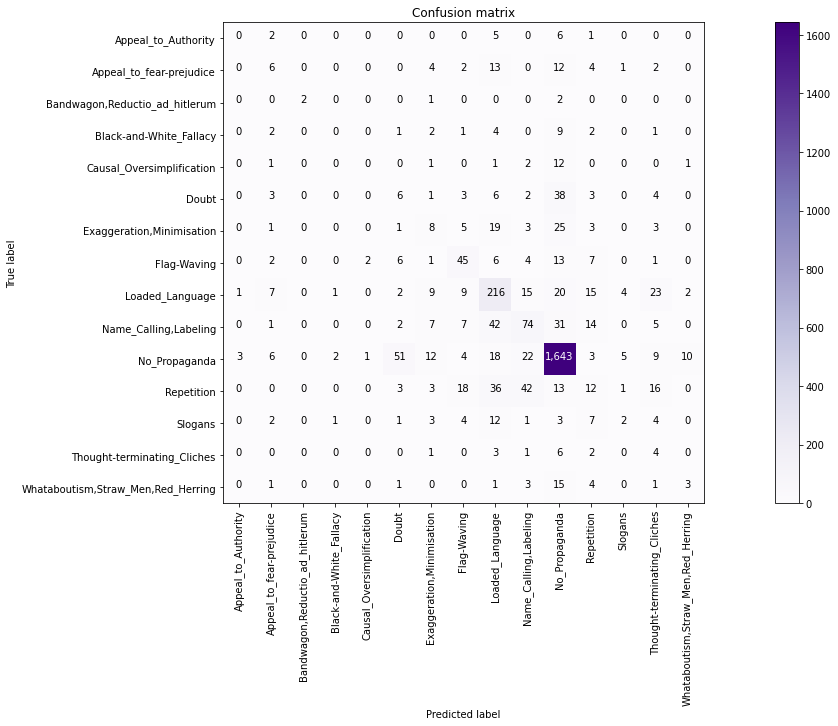

In [30]:
plot_confusion_matrix(cm = cm, target_names = labels, normalize = False)

> ### A confusion matrix visualizes the accuracy of the predictions. If a classifer had 100% accuracy then only the diagonal would contain values greater than zero. In this plot the darker purple the cell the higher the count.
> ### <span style="color:#8800ff"> The plot above shows the performance of the best logistic regression model on the dev data after fitting it on all of the training data. Comparing this matrix to the one from dummy_classifier.ipynb it may be difficult to note significant differences although there are a number of them. For instance, comparing the two matrices along the diagonal we have No_Propaganda 1,643 vs. 1,108, Loaded_Language 216 vs. 45, and Name_Calling,Labeling 74 vs. 8.

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(dev_df["label"], lr_y_pred, target_names=labels))

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        14
          Appeal_to_fear-prejudice       0.18      0.14      0.15        44
    Bandwagon,Reductio_ad_hitlerum       1.00      0.40      0.57         5
           Black-and-White_Fallacy       0.00      0.00      0.00        22
         Causal_Oversimplification       0.00      0.00      0.00        18
                             Doubt       0.08      0.09      0.09        66
         Exaggeration,Minimisation       0.15      0.12      0.13        68
                       Flag-Waving       0.46      0.52      0.49        87
                   Loaded_Language       0.57      0.67      0.61       324
             Name_Calling,Labeling       0.44      0.40      0.42       183
                     No_Propaganda       0.89      0.92      0.90      1789
                        Repetition       0.16      0.08      0.11       144
           

> ### We can evaluate the label-specific precision, recall, and f1 score results for the logistic regression model. This is a more precise way of viewing the information contained in the plot above.
> ### <span style="color:#8800ff"> Overall, the logistic regression model performed much better than the dummy classifier. However, it still struggled with Appeal_to_Authority, Black-and-White_Fallacy, and Causal_Oversimplification failing to correctly predict any of the 54 instances between them. Although the model was able to correctly predict labels from classes of similar sizes like Bandwagon,Reductio_ad_hitlerum and Whataboutism,Straw_Men,Red_Herring.

In [33]:
from sklearn.metrics import f1_score
round(f1_score(dev_df["label"], lr_y_pred, average = 'micro'),2)

0.71

> ### <span style="color:#8800ff"> Finally, we can quantify the overall performance of the model using the micro f1 score. The logistic regression model we created and evaluated above is a significant improvement over our baseline model but we have another model still to go: the BERT-based model.

# <span style="color:#FF8800"> END